In [1]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset folders
dataset_list = ['A', 'B1', 'B2', 'C', 'D']
dataset_list = ['A']

current_dir = os.getcwd()
base_path = '' + current_dir + '/test_data'
print(base_path)
# base_path = './test_data'

# Quality labels to predict
quality_labels = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']

# Collect all merged CSVs
all_dfs = []
print("Loading CSV files...")
for dataset in tqdm(dataset_list, desc="Datasets"):
    path_pattern = os.path.join(base_path + dataset, '*.csv')  # <-- match all CSVs
    print(f"Searching in: {path_pattern}")
    for file_path in glob(path_pattern):
        try:
            df = pd.read_csv(file_path, dtype=str)
            # print(f"Loaded {file_path} with shape {df.shape}")
            df['source_dataset'] = dataset  # Optional: keep track of source
            all_dfs.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
# # Combine all data

/Users/stevenjiang/Documents/GitHub/293N-YT-ABR-Prediction/test_data
Loading CSV files...


Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

Searching in: /Users/stevenjiang/Documents/GitHub/293N-YT-ABR-Prediction/test_dataA/*.csv


Datasets: 100%|██████████| 1/1 [00:29<00:00, 29.46s/it]


In [2]:
print(all_dfs)

[           RelativeTime PacketsSent PacketsReceived BytesSent BytesReceived  \
0                   0.0           1               0       159             0   
1                   0.1          24              15      3771          3874   
2                   0.2          19              19      9372          6966   
3                   0.3           1               1       332          1143   
4                   0.4           8               5      5892          4339   
...                 ...         ...             ...       ...           ...   
6005   600.500000000068           0               0         0             0   
6006   600.600000000068           0               0         0             0   
6007   600.700000000068           0               0         0             0   
6008   600.800000000068           0               0         0             0   
6009  600.9000000000681           0               0         0             0   

              IPSrc0           IPDst0 Protocol0 Pa

In [3]:
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")
print(data.columns)

Combining CSVs into one DataFrame...
Total rows loaded: 2091480
Index(['RelativeTime', 'PacketsSent', 'PacketsReceived', 'BytesSent',
       'BytesReceived', 'IPSrc0', 'IPDst0', 'Protocol0', 'PacketsSent0',
       'PacketsReceived0',
       ...
       'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p', 'BufferHealth',
       'BufferProgress', 'BufferValid', 'source_dataset'],
      dtype='object', length=208)


In [4]:
# Drop rows with missing target values
quality_to_index = {q: i for i, q in enumerate(quality_labels)}

data[quality_labels]

df_numeric = data[quality_labels].applymap(lambda x: pd.to_numeric(x, errors='coerce'))

#data[quality_labels].idxmax(axis=1)

#.map(quality_to_index)

# data['PlaybackQuality'] = data[quality_labels].idxmax(axis=1).map(quality_to_index)
# print("Filtering out rows with no quality label...")
# data = data.dropna(subset=['PlaybackQuality'])

In [5]:
# df_numeric.idxmax(axis=1).map(quality_to_index)
data['PlaybackQuality'] = df_numeric.idxmax(axis=1).map(quality_to_index)
print("Filtering out rows with no quality label...")
data = data.dropna(subset=['PlaybackQuality'])

Filtering out rows with no quality label...


In [6]:
data

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,q480p,q720p,q1080p,q1440p,q2160p,BufferHealth,BufferProgress,BufferValid,source_dataset,PlaybackQuality
0,0.0,1,0,159,0,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
1,0.1,24,15,3771,3874,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2,0.2,19,19,9372,6966,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
3,0.3,1,1,332,1143,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
4,0.4,8,5,5892,4339,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091475,600.500000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2091476,600.600000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2091477,600.700000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2091478,600.800000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0


In [7]:
# Wrap in tqdm for progress bar
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    data[col] = pd.to_numeric(data[col], errors='ignore')
print(data)


Converting columns to numeric: 100%|██████████| 209/209 [05:58<00:00,  1.72s/it]


         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        159              0   
1                 0.1           24               15       3771           3874   
2                 0.2           19               19       9372           6966   
3                 0.3            1                1        332           1143   
4                 0.4            8                5       5892           4339   
...               ...          ...              ...        ...            ...   
2091475         600.5            0                0          0              0   
2091476         600.6            0                0          0              0   
2091477         600.7            0                0          0              0   
2091478         600.8            0                0          0              0   
2091479         600.9            0                0          0              0   

                 IPSrc0    

In [8]:
# Drop original quality columns
data = data.drop(columns=quality_labels)
print(data)
# # Drop non-numeric BECAUSE RF DOESNT WORK ON NON NUMERICS
# non_feature_cols = ['IPSrc0', 'IPDst0', 'Protocol0', 'source_dataset',
#                     'CollectData', 'StartTime', 'UnlabelledQuality']
# data = data.drop(columns=[col for col in non_feature_cols if col in data.columns], errors='ignore')

# # Remove IP and protocol columns (non-numeric)
# data = data[[col for col in data.columns if not any(proto in col for proto in ['IPSrc', 'IPDst', 'Protocol'])]]

# Drop any remaining non-numeric columns
data = data.select_dtypes(include=['number', 'bool'])
print(data)

         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        159              0   
1                 0.1           24               15       3771           3874   
2                 0.2           19               19       9372           6966   
3                 0.3            1                1        332           1143   
4                 0.4            8                5       5892           4339   
...               ...          ...              ...        ...            ...   
2091475         600.5            0                0          0              0   
2091476         600.6            0                0          0              0   
2091477         600.7            0                0          0              0   
2091478         600.8            0                0          0              0   
2091479         600.9            0                0          0              0   

                 IPSrc0    

In [9]:

# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']


In [10]:
print(y)
print(X)

0          0
1          0
2          0
3          0
4          0
          ..
2091475    0
2091476    0
2091477    0
2091478    0
2091479    0
Name: PlaybackQuality, Length: 2091480, dtype: int64
         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        159              0   
1                 0.1           24               15       3771           3874   
2                 0.2           19               19       9372           6966   
3                 0.3            1                1        332           1143   
4                 0.4            8                5       5892           4339   
...               ...          ...              ...        ...            ...   
2091475         600.5            0                0          0              0   
2091476         600.6            0                0          0              0   
2091477         600.7            0                0          0             

In [11]:

# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
for i in tqdm(range(1), desc="Training"):
    clf.fit(X_train, y_train)

# Evaluate
print("\nEvaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...


Training: 100%|██████████| 1/1 [00:21<00:00, 21.51s/it]



Evaluating model...



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51552
           1       1.00      1.00      1.00     39581
           2       1.00      1.00      1.00     45091
           3       1.00      1.00      1.00     82064
           4       1.00      1.00      1.00    125600
           5       1.00      1.00      1.00     74408

    accuracy                           1.00    418296
   macro avg       1.00      1.00      1.00    418296
weighted avg       1.00      1.00      1.00    418296



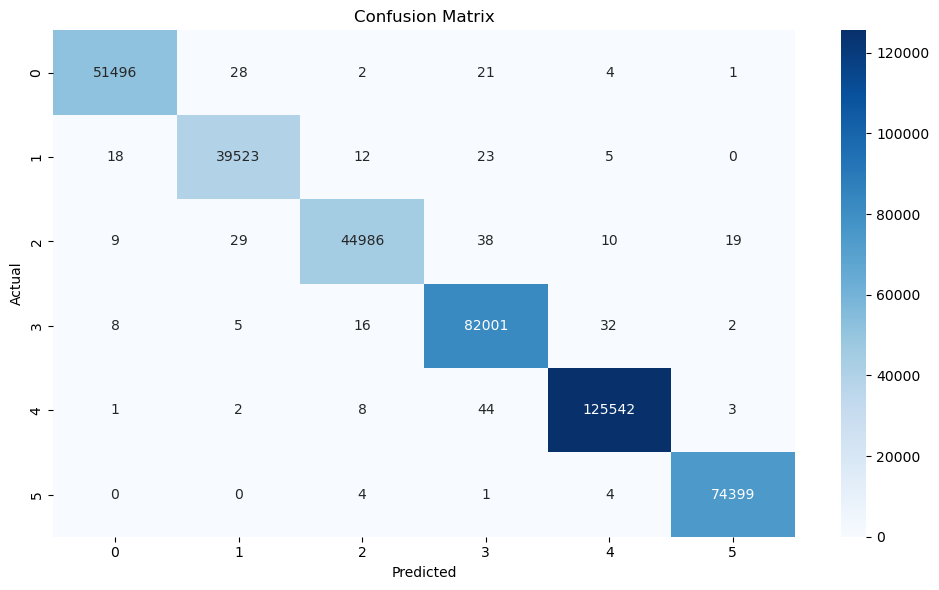

In [12]:
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=le.classes_))
# Convert the integer labels back to string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

# Classification report with string labels
print("\nClassification Report:")
print(classification_report(y_test_str, y_pred_str, target_names=le.classes_.astype(str)))
# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [14]:
pip install trustee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.7/328.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 21.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sphinxemoji: filename=sphinxemoji-0.2.0-py3-none-any.whl size=44409 sha256=c3fda8ae16451c66ad6e6bb095eae141f25b99f3460b02529bf495dba1526022
  Stored in directory: /Users/stevenjiang/Library/Caches/pip/wheels/2b/12/1c/c58487270d860c94a2f2274555f1d04471343295f738458e8e
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=26daf5d174f6267b82ceaaaf3152992997aa3c2ba924bc75a060

In [15]:
from trustee import ClassificationTrustee

# Apply ClassificationTrustee
trustee = ClassificationTrustee(expert=clf)

# Fit the trustee model to the training data
trustee.fit(X_train, y_train, num_iter=2, num_stability_iter=2, samples_size=0.3, verbose=True)

# Get the explanation (decision tree and other metrics)
dt, pruned_dt, agreement, reward = trustee.explain()

# Predict using the pruned decision tree
dt_y_pred = dt.predict(X_test)

# Print the global fidelity report
print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))

# Print the explanation score report
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(n_estimators=10, random_state=42) as expert model
Expert model score: 0.9999827674698158
Initializing Trustee outer-loop with 2 iterations
########## Outer-loop Iteration 0/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 351368 points from training dataset with (1171228, 1171228) entries
Student model 0-0 trained with depth 17 and 265 leaves:
Student model score: 0.9994184489820263
Student model 0-0 fidelity: 0.9994184489820263
########## Inner-loop Iteration 1/2 ##########
Sampling 351368 points from training dataset with (1276639, 1276639) entries
Student model 0-1 trained with depth 17 and 289 leaves:
Student model score: 0.9991943289110753
Student model 0-1 fidelity: 0.9991943289110753
########## Outer-loop Iteration 1/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 351368 points from

/Users/stevenjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51532
           1       1.00      1.00      1.00     39587
           2       1.00      1.00      1.00     45028
           3       1.00      1.00      1.00     82128
           4       1.00      1.00      1.00    125597
           5       1.00      1.00      1.00     74424

    accuracy                           1.00    418296
   macro avg       1.00      1.00      1.00    418296
weighted avg       1.00      1.00      1.00    418296

Model explanation score report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51552
           1       1.00      1.00      1.00     39581
           2       1.00      1.00      1.00     45091
           3       1.00      1.00      1.00     82064
           4       1.00      1.00      1.00    125600
           5       1.00      1.00      1.00     74408

   

In [16]:
# I've run this and it works up until saving
from trustee.report.trust import TrustReport
OUTPUT_PATH = "./test"
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

target_names = y.unique()  # Get unique values from y, which is PlaybackQuality
feature_names = X.columns.tolist()  # Get the column names from the DataFrame for the features

trust_report = TrustReport(
    clf,
    X_train=X_train,  # Pass the training data
    X_test=X_test,  # Pass the testing data
    y_train=y_train,  # Pass the training target values
    y_test=y_test,  # Pass the testing target values
    max_iter=1,  # Minimum iterations for the main process
    num_pruning_iter=1,  # Minimum pruning iterations
    train_size=0.7,
    trustee_num_iter=1,  # Minimum trustee iterations
    trustee_num_stability_iter=1,  # Minimum stability iterations
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=5,  # Analyze top 5 feature importance
    verbose=True,
    class_names=target_names,
    feature_names=feature_names,
    is_classify=True,
)
print(trust_report)
trust_report.save(OUTPUT_PATH)

Running Trust Report...
Preparing data...
Done!
Progress |----------------------------------------------------------------------------------------------------| 0.9% Complete
Done!
Progress |█---------------------------------------------------------------------------------------------------| 1.8% Complete
Fitting blackbox model...
Done!
Blackbox model score report with training data:

              precision    recall  f1-score   support

           0      0.999     0.999     0.999     77243
           1      0.999     0.998     0.998     59552
           2      0.999     0.997     0.998     67758
           3      0.998     0.999     0.998    122812
           4      0.999     0.999     0.999    188317
           5      1.000     1.000     1.000    111762

    accuracy                          0.999    627444
   macro avg      0.999     0.999     0.999    627444
weighted avg      0.999     0.999     0.999    627444

Using Classification Trustee algorithm to extract DT...
Initializing t

OSError: [Errno 28] No space left on device

In [17]:
# This one might actually work?
from trustee.report.trust import TrustReport

OUTPUT_PATH = "./test"

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

target_names = [str(name) for name in y.unique()]  # Convert target labels to strings
feature_names = X.columns.tolist()  # Feature column names

trust_report = TrustReport(
    clf,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    max_iter=1,
    num_pruning_iter=1,
    train_size=0.7,
    trustee_num_iter=1,
    trustee_num_stability_iter=1,
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=1,
    verbose=True,
    class_names=target_names,
    feature_names=feature_names,
    is_classify=True,
)

print(trust_report)
trust_report.save(OUTPUT_PATH)


Running Trust Report...
Preparing data...
Done!
Progress |----------------------------------------------------------------------------------------------------| 0.9% Complete
Done!
Progress |█---------------------------------------------------------------------------------------------------| 1.8% Complete
Fitting blackbox model...
Done!
Blackbox model score report with training data:

              precision    recall  f1-score   support

           0      0.999     0.999     0.999     77243
           1      0.999     0.998     0.998     59552
           2      0.999     0.997     0.998     67758
           3      0.998     0.999     0.998    122812
           4      0.999     0.999     0.999    188317
           5      1.000     1.000     1.000    111762

    accuracy                          0.999    627444
   macro avg      0.999     0.999     0.999    627444
weighted avg      0.999     0.999     0.999    627444

Using Classification Trustee algorithm to extract DT...
Initializing t

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [18]:
import pickle

# Load the TrustReport object
with open("./test/report/trust_report.obj", "rb") as f:
    trust_report_loaded = pickle.load(f)

# Now you can access its methods or attributes
print(trust_report_loaded)


ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [ ]:
# Generates shit ton of PDFs in the outputdir errors out a bit
trust_report_loaded.plot("./output_dir")  # Re-plot visuals


In [ ]:
print(trust_report_loaded.max_dt)  # Print the decision tree with highest trust
print(trust_report_loaded.feature_names)  # See the feature names
